# Task 1
Investigate at least 4 different clustering methods on the "CancerData.txt" data set.

Consider different dimension and feature selection techniques. Remember - it's a clustering task so you cannot select based on the class label!!!

Questions to focus on:

- Do the detected clusters overlap with the classes? Do some classes stand out?

- Do cluster selection methods (try at least 2) propose 3 clusters or more/fewer?

- How sensitive are any of the results above to how many features or reduced dimensions you use? and does this depend on which clustering method you use?

- How stable are the clustering results (investigate via resampling, consensus clustering etc)?


# Task 2a
Create cluster-irrelevant features in the data by e.g. perturbing features or replace with simulated noise features. Note, it is probably easier if you first filter out some cluster relevant features so you have an informative set to start from and keep these intact, but you are free to investigate the question of noisy features in other ways if you prefer.

Investigate how an increasing proportion of cluster-irrelevant features impact clustering and the selection of the number of clusters. Is this sensitive to how you choose to reduce dimensions or select features?

To make this interesting, explore at least 2-3 dimension reduction techniques. You can consider feature selection methods, projections, factorization methods or auto-encoders for example.

## Data preparation

In [1]:
import numpy as np

labels = list()

with open('Cancerdata.txt') as f:
    lines = f.readlines()
    for i, line in enumerate(lines):
        if i == 0:
            continue
        line = line.split('\t')
        line = [item.rstrip() for item in line]
        line[0] = float(line[0].strip('"'))
        line[1:] = [float(x) for x in line[1:]]
        line = np.asarray(line)
        
        # Append labels
        labels.append(int(line[1]))
        
        # Create the data np.array with first observation
        # Vstack the rest of the observations to the newly created data matrix
        observation = line[2:]
        if i == 1:
            data = observation
        else:
            data = np.vstack((data, observation))
        
labels = np.asarray(labels)

print(np.shape(labels))
print(np.shape(data))

(82,)
(82, 2999)


### Plot functions

In [2]:
def plot_true_vs_predict_2d(true_labels, predicted_labels, pca_component1=None, pca_component2=None):
    pca_component1 = 0 if pca_component1 is None else pca_component1
    pca_component2 = 1 if pca_component2 is None else pca_component2

    colors = ['red', '#7FFF00', 'blue']
    plt.figure(3)

    for i in u_labels:
        plt.scatter(principal_components_pca[predicted_labels == i , pca_component1] , principal_components_pca[predicted_labels == i , pca_component2] , label = i, color=colors[i])
        plt.scatter(principal_components_pca[true_labels == i , pca_component1] , principal_components_pca[true_labels == i , pca_component2] , label = i, marker="x", color=colors[i], zorder=5)

    plt.title('Plot of the real-label and kMean-label')
    plt.xlabel('Principal component ' + str(pca_component1+1))
    plt.ylabel('Principal component ' + str(pca_component2+1))

In [3]:
def plot_true_vs_predict_3d(true_labels, predicted_labels, pca_component1=None, pca_component2=None, pca_component3 = None):
    pca_component1 = 0 if pca_component1 is None else pca_component1
    pca_component2 = 1 if pca_component2 is None else pca_component2
    pca_component3 = 2 if pca_component3 is None else pca_component3

    colors = ['red', '#7FFF00', 'blue']
    fig = plt.figure()
    ax = fig.add_subplot(111, projection ='3d')


    for i in u_labels:
        plt.scatter(principal_components_pca[predicted_labels == i , pca_component1] , principal_components_pca[predicted_labels == i , pca_component2], principal_components_pca[predicted_labels == i , pca_component3] , label = i, color=colors[i])
        plt.scatter(principal_components_pca[true_labels == i , pca_component1] , principal_components_pca[true_labels == i , pca_component2], principal_components_pca[true_labels == i , pca_component3], label = i, marker="x", color=colors[i], zorder=5)

    plt.title('Plot of the real-label and kMean-label')
    plt.xlabel('Principal component ' + str(pca_component1+1))
    plt.ylabel('Principal component ' + str(pca_component2+1))

In [171]:
import math
import pandas as pd
from matplotlib.patches import Rectangle

def plot_difference_real(true_labels, predicted_labels, pca_component1=None, pca_component2=None):
    pca_component1 = 0 if pca_component1 is None else pca_component1
    pca_component2 = 1 if pca_component2 is None else pca_component2

    fig, ax1 = plt.subplots(1)
    
    #Vi vill ha den kvadratisk för att enklare kunna se clusters
    fig.set_size_inches(7, 7)
    
    custom_xlim = (-30, 30)
    custom_ylim = (-30, 30)
    plt.setp(ax, xlim=custom_xlim, ylim=custom_ylim)
    
    colors_fill = ['#C7054C', '#1E88E5', '#FFC107']
    colors_edge = ['#8A072B', '#0068C3', '#BF9001']
    
    markers = ['o', 's', 'v']
    
    #Plottar alla clusters med Färg = predikt, marker = true
    
    for i in range(len(true_labels)):
        component = [principal_components_pca[i , pca_component1], 
                             principal_components_pca[i, pca_component2]]
        ax1.scatter(component[0], component[1], color=colors_fill[predicted_labels[i]], 
                    marker = markers[true_labels[i]], edgecolor = colors_edge[predicted_labels[i]])
    
    
        ax1.set_xlabel('Principal component ' + str(pca_component1+1))
        ax1.set_ylabel('Principal component ' + str(pca_component2+1))
        ax1.set_title('Real and predicted clusters')
        
        extra1 = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)
        extra2 = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)
        
        ax1.legend([extra1, extra2], ("Shape = true", "Colour = Predicted")) 

In [123]:
def get_wrong_info(true_labels, predicted_labels, pca_component1=None, pca_component2=None):
    pca_component1 = 0 if pca_component1 is None else pca_component1
    pca_component2 = 1 if pca_component2 is None else pca_component2
    
    nr_of_wrong = np.zeros(3)
    nr_of_missed = np.zeros(3)
    
    #Vi loopar igenom alla tre clusters.
    for pred in range(3):
        max_common = 0
        max_cluster = 0
        
        #Väljer ut det pred. clustret vi tittar på och vill finna info om
        predicted_cluster = np.array([principal_components_pca[predicted_labels == pred , pca_component1], 
                             principal_components_pca[predicted_labels == pred , pca_component2]])

        
        #Loopar igenom "orginal-clustern"
        for j in range(3):
            common = 0   
            true_cluster = np.array([principal_components_pca[true_labels == j , pca_component1], 
                            principal_components_pca[true_labels == j , pca_component2]])
            
            #Ser hur många som överrensstämmer i de två clusterna
            for i in range(predicted_cluster.shape[1]):
                for k in range(true_cluster.shape[1]):
                    if np.array_equal(true_cluster[0:2, k], predicted_cluster[0:2, i]):
                        common += 1

            #Tar ut det "orginal-clustret" som stämmer mest överrens med predicted
            if common > max_common:
                max_common = common
                max_cluster = j
        
        #Tar ut det "bästa orginal-clustret"
        cluster = np.array([principal_components_pca[true_labels == max_cluster , pca_component1], 
                            principal_components_pca[true_labels == max_cluster , pca_component2]])
        

        
        #Tar ut hur mycket som är "fel" och "missat" av det predikterade
        wrong = []
        for i in range(predicted_cluster.shape[1]):
            col_pred = predicted_cluster[0:2, i]
            not_in = 0
            
            #Checkar mot alla i den andta
            for k in range(cluster.shape[1]):
                col_true = cluster[0:2, k]
                if np.array_equal(col_pred, col_true):
                    not_in += 1

            if not_in < 1:
                wrong.append(col_pred)
             
        missed = []
        for i in range(cluster.shape[1]):
            col_pred = cluster[0:2, i]
            not_in = 0

            for k in range(predicted_cluster.shape[1]):
                col_true = predicted_cluster[0:2, k]
                if np.array_equal(col_pred, col_true):
                    not_in += 1

            if not_in < 1:
                missed.append(col_pred)

        nr_of_missed[pred] = len(missed)
        nr_of_wrong[pred] = len(wrong)
        
    #Presenterar infon om missade och fel-clustrade
    all_info = np.stack((nr_of_wrong, nr_of_missed), axis = 1)
    wrong_info = pd.DataFrame(all_info, columns = ["Number of wrong in each cluster", "Number of missed in each cluster"])#['Nr. of wrong: cluster 1','Nr. of wrong: cluster 2','Nr. of wrong: cluster 3'])

    return wrong_info
        

In [142]:
def get_average_wrong_info_kmeans(reduced_data, nr_of_itt, nr_clusters, score):

    average_wrong_info = np.zeros([3, 2])

    for i in range(nr_of_itt):
        k, pred_kmeans = kmeans_clustering_cvscore(reduced_data,  nr_clusters, score)
        wrong_info = get_wrong_info(labels, pred_kmeans)

        average_wrong_info[:, 0] += wrong_info.get("Number of wrong in each cluster")
        average_wrong_info[:, 1] += wrong_info.get("Number of missed in each cluster")


    average_wrong_info[:, 0] = average_wrong_info[:, 0]/nr_of_itt
    average_wrong_info[:, 1] = average_wrong_info[:, 1]/nr_of_itt

    wrong_info = pd.DataFrame(average_wrong_info, columns = ["Number of wrong in each cluster", "Number of missed in each cluster"])
    
    return wrong_info

In [143]:
def get_average_wrong_info_sc(reduced_data, nr_of_itt, nr_clusters, score):

    average_wrong_info = np.zeros([3, 2])

    for i in range(nr_of_itt):
        k, pred_sc = spectral_cvscore(reduced_data, nr_clusters, score)
        wrong_info = get_wrong_info(labels, pred_sc)

        average_wrong_info[:, 0] += wrong_info.get("Number of wrong in each cluster")
        average_wrong_info[:, 1] += wrong_info.get("Number of missed in each cluster")


    average_wrong_info[:, 0] = average_wrong_info[:, 0]/nr_of_itt
    average_wrong_info[:, 1] = average_wrong_info[:, 1]/nr_of_itt

    wrong_info = pd.DataFrame(average_wrong_info, columns = ["Number of wrong in each cluster", "Number of missed in each cluster"])
    
    return wrong_info

   Number of wrong in each cluster  Number of missed in each cluster
0                             7.72                              9.86
1                             9.01                              7.88
2                             6.78                              8.88


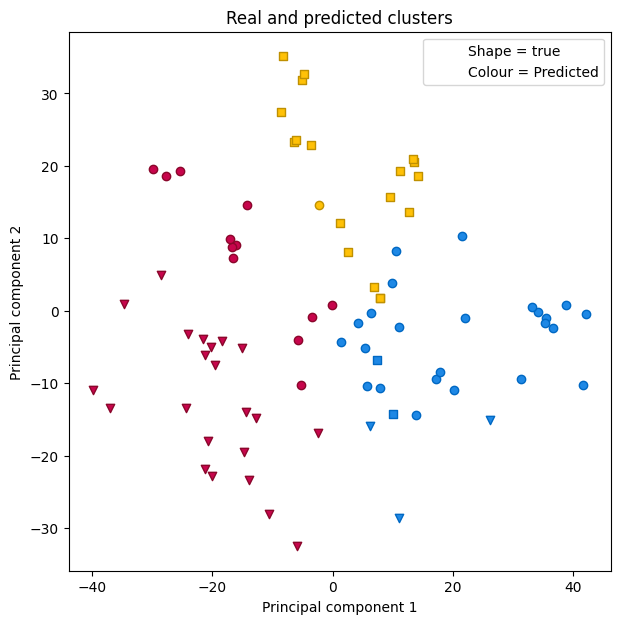

In [172]:
reduced_data = pca(data, 10)
nr_of_itt = 100

wrong_info = get_average_wrong_info_kmeans(reduced_data, nr_of_itt, 3, 'kmean')
print(wrong_info)
plot_difference_real(labels, pred_kmeans)

   Number of wrong in each cluster  Number of missed in each cluster
0                              1.0                              15.0
1                              0.0                               0.0
2                             15.0                               1.0


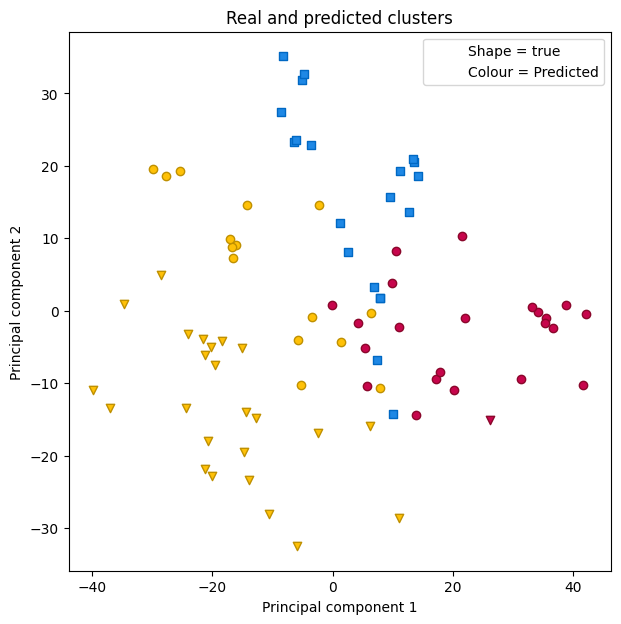

In [173]:
reduced_data = pca(data, 10)
nr_of_itt = 100

wrong_info = get_average_wrong_info_sc(reduced_data, nr_of_itt, 3, 'kmean')
print(wrong_info)

k, pred_sc = spectral_cvscore(reduced_data, 3, 'kmean')
plot_difference_real(labels, pred_sc)

## Step 1

### Dimension and feature selection techniques suited for unsupervised clustering tasks

1. Principal Component Analysis (PCA)
2. Independent Component Analysis (ICA)
3. Random Projections
4. Feature Selection based on Clustering Quality
5. Recursive Feature Elimination (RFE)

Principal Component Analysis (PCA): PCA is a technique that reduces the dimensionality of the data by identifying the most important features that capture the most variance in the data. PCA is a powerful technique for feature selection, as it can often reduce the number of features required for clustering while still retaining the important information.

Independent Component Analysis (ICA): ICA is a technique that separates the data into independent sources based on statistical properties. ICA can be used for feature selection by identifying the features that have the most independent information, which can help to remove redundant or noisy features.

Random Projections: Random projections is a technique that can be used to reduce the dimensionality of the data by projecting the data onto a lower-dimensional subspace. Random projections can be used for feature selection by identifying the most important dimensions that capture the most variance in the data.

Feature Selection based on Clustering Quality: This approach selects the features that produce the best clustering results. This method works by selecting a subset of features and evaluating the clustering performance with different clustering algorithms, and selecting the subset of features that results in the best clustering performance.

Recursive Feature Elimination (RFE): RFE is a feature selection method that selects features by recursively considering smaller and smaller subsets of features. RFE works by training a model on the full set of features, ranking the importance of the features, and then eliminating the least important feature. This process is repeated until a predetermined number of features is reached.

## PCA

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


data_pp = StandardScaler().fit_transform(data)
pca = PCA(svd_solver="auto").fit(data_pp)
# The PCA object offers convenient ways of accessing the
# principal directions and explained variance
pca.components_;
pca.explained_variance_;

# To get the principal components, the `transform` method of the
# PCA object can be used
principal_components_pca = pca.transform(data_pp)

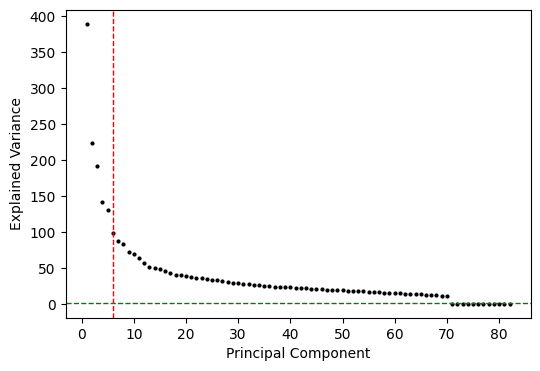

In [6]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(6, 4))
ax = fig.gca()

ax.plot(np.arange(1, len(pca.components_) + 1), pca.explained_variance_, 'ok', markersize=2)
ax.axvline(6, linestyle="dashed", color="red", linewidth=1)
ax.axhline(1, linestyle="dashed", color="green", linewidth=1)

ax.set_xlabel("Principal Component")
ax.set_ylabel("Explained Variance");

In [7]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def pca(data, n_components):
    # Scale the data
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data)
    
    # Fit PCA to the scaled data
    pca = PCA(n_components=n_components)
    pca.fit(scaled_data)
    
    # Transform the data using the fitted PCA model
    principal_components = pca.transform(scaled_data)
    
    # Return the principal components and explained variance ratio
    return principal_components

### Random projection

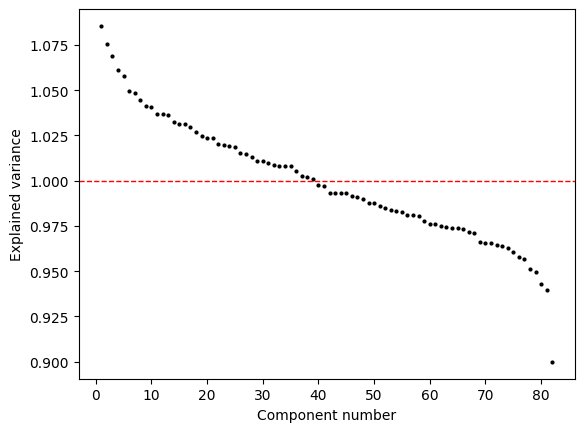

Number of components = 39


In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.random_projection import GaussianRandomProjection

rp = GaussianRandomProjection(n_components=82).fit(data)

# Compute the explained variance ratio for each component
explained_variances = np.abs(rp.components_).var(axis=1) / np.abs(rp.components_).var().sum()

# Sort the components based on their explained variance
sorted_indices = np.argsort(explained_variances)[::-1]
explained_variances_sorted = explained_variances[sorted_indices]# Compute the explained variance ratio for each component
explained_variances = np.abs(rp.components_).var(axis=1) / np.abs(rp.components_).var().sum()

# Sort the components based on their explained variance
sorted_indices = np.argsort(explained_variances)[::-1]
explained_variances_sorted = explained_variances[sorted_indices]

# Plot the scree plot
plt.plot(np.arange(1, len(explained_variances) + 1), explained_variances_sorted, 'ok',markersize=2)
plt.axhline(1, linestyle="dashed", color="red", linewidth=1)
plt.xlabel('Component number')
plt.ylabel('Explained variance')
plt.show()

n_components = np.sum(explained_variances_sorted > 1)
print(f'Number of components = {n_components}')

In [10]:
def random_projection(data, nr_components):
    scaled_data = StandardScaler().fit_transform(data)
    return GaussianRandomProjection(n_components=nr_components).fit_transform(scaled_data)
    

In [11]:
nr_components_list = [5, 10, 20, 30]
nr_clusters_list = [1, 2, 3, 4, 5]
#Calinski-harbaz score
#Davies-Bouldin

def crossval(fun, nr_clusters_list, nr_components_list):
    for component in nr_components_list:
        reduced_data = pca(data, component)
        for cluster in nr_clusters_list:
            if fun == 'kmeans':
                score, pred_label = kmeans_clustering_cvscore(reduced_data, cluster)
            elif fun == 'spectral':
                score = spectral_cvscore(reduced_data, cluster)
            print(score)
    return pred_label

## Clustering methods

In [28]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import davies_bouldin_score
from sklearn.cluster import SpectralClustering

def kmeans_clustering_cvscore(reduced_data, nr_clusters, score):
    kmeans = KMeans(init="k-means++", n_clusters=nr_clusters, n_init='auto').fit(reduced_data)
    pred = kmeans.labels_
    if score == 'silh':
        score = silhouette_score(reduced_data, pred, metric='euclidean')
    elif score == 'calinski':
        score = calinski_harabasz_score(reduced_data, pred)
    elif score == 'davies':
        score = davies_bouldin_score(reduced_data, pred)
    return score, pred

def spectral_cvscore(reduced_data, nr_clusters, score):
    sc = SpectralClustering(n_clusters=nr_clusters, eigen_solver='lobpcg', n_init=10, gamma=1.0, affinity='nearest_neighbors',
                        n_neighbors=10, assign_labels='cluster_qr')
    pred = sc.fit_predict(reduced_data)
    if score == 'silh':
        score = silhouette_score(reduced_data, pred, metric='euclidean')
    elif score == 'calinski':
        score = calinski_harabasz_score(reduced_data, pred)
    elif score == 'davies':
        score = davies_bouldin_score(reduced_data, pred)
    return score, pred


def something_cvscore(reduced_data, nr_clusters, score):
    clf = ...
    pred = clf.fit_predict(reduced_data)
    if score == 'silh':
        score = silhouette_score(reduced_data, pred, metric='euclidean')
    elif score == 'calinski':
        score = calinski_harabasz_score(reduced_data, pred)
    elif score == 'davies':
        score = davies_bouldin_score(reduced_data, pred)
    return score, pred


def something_cvscore(reduced_data, nr_clusters, score):
    clf = ...
    pred = clf.fit_predict(reduced_data)
    if score == 'silh':
        score = silhouette_score(reduced_data, pred, metric='euclidean')
    elif score == 'calinski':
        score = calinski_harabasz_score(reduced_data, pred)
    elif score == 'davies':
        score = davies_bouldin_score(reduced_data, pred)
    return score, pred

NameError: name 'pred_kmeans' is not defined

In [13]:
from tqdm import trange
from tqdm import tqdm
import numpy as np

def evaluate(nr_PC, nr_clusters_list, data, method, iterations, metric):
    reduced_data = pca(data, nr_PC)
    cluster_dict = {}
    
    for c in nr_clusters_list:
        score_list = []
        for i in tqdm(range(iterations), desc=f"Number of clusters {c}", position=0):
            if method == 'kmeans':
                score, pred_label = kmeans_clustering_cvscore(reduced_data, c, metric)
            elif method == 'spectral':
                score, pred_label = spectral_cvscore(reduced_data, c, metric)
            score_list.append(score)
            
        cluster_dict[c] = np.mean(score_list)
    return cluster_dict, pred_label


***Taking out scores for the different metrics that depends on the nr of clusters***

In [14]:
# Function arguments
nr_clusters_list = [2, 3, 4, 5]
#nr_PC = [5, 10, 20, 30, 82]
nr_PC = 5
method = 'spectral'
iterations = 100

silhouette_score_dict, pred_label = evaluate(nr_PC, nr_clusters_list, data, method, iterations, 'silh')
print(f'Silhoutte scores for {method}:\n {silhouette_score_dict}')

calinski_score_dict, pred_label = evaluate(nr_PC, nr_clusters_list, data, method, iterations, 'calinski')
print(f'Calinski-Harabasz scores for {method}:\n {calinski_score_dict}')

davies_bouldin_dict, pred_label = evaluate(nr_PC, nr_clusters_list, data, method, iterations, 'davies')
print(f'Davies-Bouldin scores for {method}:\n {davies_bouldin_dict}')

Number of clusters 3:  92%|██████████████████████████████████████████████████████▎    | 92/100 [00:02<00:00, 32.26it/s]C:\Users\elinh\OneDrive\Skrivbord\Big Data\venvBigData\lib\site-packages\sklearn\manifold\_spectral_embedding.py:393: UserWarning: Exited at iteration 77 with accuracies 
[1.74857736e-05 9.02485212e-08 2.29195194e-04 1.04953922e-04]
not reaching the requested tolerance 1.2218952178955078e-06.
Use iteration 43 instead with accuracy 
1.875789371284796e-06.

  _, diffusion_map = lobpcg(
C:\Users\elinh\OneDrive\Skrivbord\Big Data\venvBigData\lib\site-packages\sklearn\manifold\_spectral_embedding.py:393: UserWarning: Exited postprocessing with accuracies 
[1.39285583e-11 6.02918233e-06 9.08473937e-08 2.98770746e-01]
not reaching the requested tolerance 1.2218952178955078e-06.
  _, diffusion_map = lobpcg(
Number of clusters 5: 100%|██████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 48.90it/s]


Silhoutte scores for spectral:
 {2: 0.15311015821280272, 3: 0.24880466567959136, 4: 0.2602726717546125, 5: 0.27962316940394333}


Number of clusters 5: 100%|██████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 60.73it/s]


Calinski-Harabasz scores for spectral:
 {2: 13.880142093467366, 3: 25.347005448526208, 4: 25.026464641305424, 5: 26.079454017286874}


Number of clusters 4:  46%|███████████████████████████▏                               | 46/100 [00:00<00:01, 45.91it/s]C:\Users\elinh\OneDrive\Skrivbord\Big Data\venvBigData\lib\site-packages\sklearn\manifold\_spectral_embedding.py:393: UserWarning: Exited at iteration 19 with accuracies 
[5.77262916e-16 1.27251474e-07 8.82396157e-08 9.58548967e-07
 1.27824990e-06]
not reaching the requested tolerance 1.2218952178955078e-06.
Use iteration 19 instead with accuracy 
4.904579916972285e-07.

  _, diffusion_map = lobpcg(
C:\Users\elinh\OneDrive\Skrivbord\Big Data\venvBigData\lib\site-packages\sklearn\manifold\_spectral_embedding.py:393: UserWarning: Exited postprocessing with accuracies 
[6.12045913e-16 1.27251474e-07 8.82396157e-08 9.58548967e-07
 1.27824990e-06]
not reaching the requested tolerance 1.2218952178955078e-06.
  _, diffusion_map = lobpcg(
Number of clusters 5: 100%|██████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 50.76it/s]

Davies-Bouldin scores for spectral:
 {2: 1.7514330201279664, 3: 1.370573084087926, 4: 1.4167017973584128, 5: 1.3173615793611422}


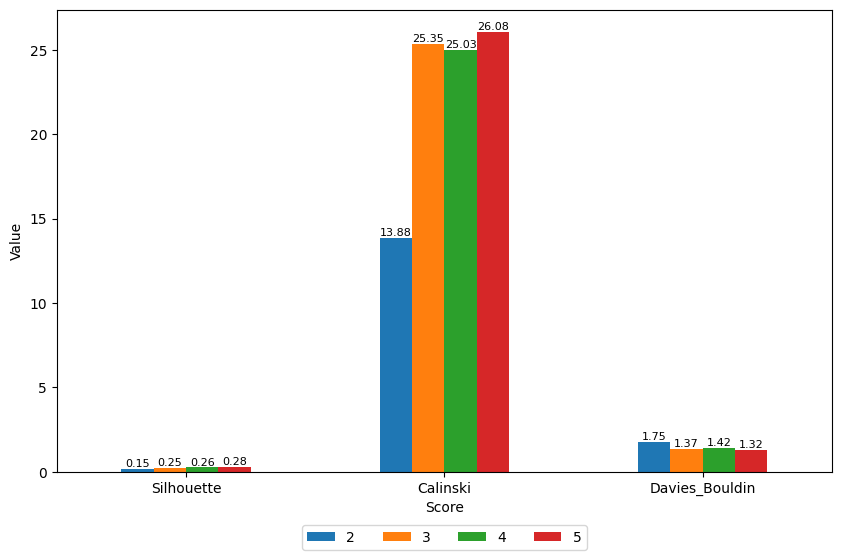

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
clfs_name = ['2', '3', '4', '5']
def barplot(score_values, score_names):
    df = pd.DataFrame(score_values, index=score_names, columns=clfs_name)
    ax = df.plot.bar(rot=0, figsize=(10,6))
    
    
    # Add score names below the bars
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=len(clfs_name))
    ax.set_xlabel('Score')
    ax.set_ylabel('Value')
    ax.set_xticklabels(score_names)
    
    # Add exact values above the bars
    for i in ax.containers:
        ax.bar_label(i, label_type='edge', fmt='%.2f', fontsize=8)
    
    plt.show()
        
score_values = [silhouette_score_dict.values(), calinski_score_dict.values(), davies_bouldin_dict.values()]
score_names = ['Silhouette', 'Calinski', 'Davies_Bouldin']
barplot(score_values, score_names)

***Investigate how sensitive the results are to the nr of principal components***

In [15]:
from collections import Counter
from collections import defaultdict

def pc_check(method, score_name, nr_clusters_list):
    my_dict = defaultdict(list)
    nr_PC = [5, 10, 20, 30, 82]
    iterations = 100

    for pc in nr_PC:
        score_dict, pred_label = evaluate(pc, nr_clusters_list, data, method, iterations, score_name)
        best_score = 0
        for key, val in score_dict.items():
            my_dict[key].append(val)
    return my_dict

In [16]:
# creating a function that spits out all the variances for each clustering method in a dict for a specified score metric
nr_clusters_list = [2, 3, 4, 5]
def variances(cluster_methods:list, score_metric:str, clusters:list):
    variances = defaultdict(list)
    for method in cluster_methods:
        my_dict = pc_check(method,score_metric, clusters)
        for key, values in my_dict.items():
            variances[key].append(np.var(values))
    return variances
        
cluster_methods = ['kmeans', 'spectral']
silhoutte_variances = variances(cluster_methods, 'silh', nr_clusters_list)
calinski_variances = variances(cluster_methods, 'calinski', nr_clusters_list)
davies_variances = variances(cluster_methods, 'davies', nr_clusters_list)

Number of clusters 2:   0%|                                                                    | 0/100 [00:00<?, ?it/s]C:\Users\elinh\OneDrive\Skrivbord\Big Data\venvBigData\lib\site-packages\sklearn\cluster\_spectral.py:717: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
C:\Users\elinh\OneDrive\Skrivbord\Big Data\venvBigData\lib\site-packages\sklearn\cluster\_spectral.py:717: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
C:\Users\elinh\OneDrive\Skrivbord\Big Data\venvBigData\lib\site-packages\sklearn\cluster\_spectral.py:717: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
C:

Number of clusters 2:  12%|███████                                                    | 12/100 [00:00<00:02, 33.40it/s]C:\Users\elinh\OneDrive\Skrivbord\Big Data\venvBigData\lib\site-packages\sklearn\cluster\_spectral.py:717: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
C:\Users\elinh\OneDrive\Skrivbord\Big Data\venvBigData\lib\site-packages\sklearn\cluster\_spectral.py:717: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
C:\Users\elinh\OneDrive\Skrivbord\Big Data\venvBigData\lib\site-packages\sklearn\cluster\_spectral.py:717: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
C:

C:\Users\elinh\OneDrive\Skrivbord\Big Data\venvBigData\lib\site-packages\sklearn\cluster\_spectral.py:717: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
C:\Users\elinh\OneDrive\Skrivbord\Big Data\venvBigData\lib\site-packages\sklearn\cluster\_spectral.py:717: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
Number of clusters 2:  43%|█████████████████████████▎                                 | 43/100 [00:01<00:01, 47.61it/s]C:\Users\elinh\OneDrive\Skrivbord\Big Data\venvBigData\lib\site-packages\sklearn\cluster\_spectral.py:717: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
C:

C:\Users\elinh\OneDrive\Skrivbord\Big Data\venvBigData\lib\site-packages\sklearn\cluster\_spectral.py:717: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
C:\Users\elinh\OneDrive\Skrivbord\Big Data\venvBigData\lib\site-packages\sklearn\cluster\_spectral.py:717: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
Number of clusters 2:  72%|██████████████████████████████████████████▍                | 72/100 [00:01<00:00, 54.39it/s]C:\Users\elinh\OneDrive\Skrivbord\Big Data\venvBigData\lib\site-packages\sklearn\cluster\_spectral.py:717: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
C:

C:\Users\elinh\OneDrive\Skrivbord\Big Data\venvBigData\lib\site-packages\sklearn\cluster\_spectral.py:717: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
C:\Users\elinh\OneDrive\Skrivbord\Big Data\venvBigData\lib\site-packages\sklearn\cluster\_spectral.py:717: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
Number of clusters 2:  99%|██████████████████████████████████████████████████████████▍| 99/100 [00:02<00:00, 59.68it/s]C:\Users\elinh\OneDrive\Skrivbord\Big Data\venvBigData\lib\site-packages\sklearn\cluster\_spectral.py:717: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
Nu

C:\Users\elinh\OneDrive\Skrivbord\Big Data\venvBigData\lib\site-packages\sklearn\cluster\_spectral.py:717: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
C:\Users\elinh\OneDrive\Skrivbord\Big Data\venvBigData\lib\site-packages\sklearn\cluster\_spectral.py:717: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
Number of clusters 3:  25%|██████████████▊                                            | 25/100 [00:00<00:01, 41.87it/s]C:\Users\elinh\OneDrive\Skrivbord\Big Data\venvBigData\lib\site-packages\sklearn\cluster\_spectral.py:717: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
C:

C:\Users\elinh\OneDrive\Skrivbord\Big Data\venvBigData\lib\site-packages\sklearn\cluster\_spectral.py:717: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
C:\Users\elinh\OneDrive\Skrivbord\Big Data\venvBigData\lib\site-packages\sklearn\cluster\_spectral.py:717: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
Number of clusters 3:  53%|███████████████████████████████▎                           | 53/100 [00:01<00:01, 46.10it/s]C:\Users\elinh\OneDrive\Skrivbord\Big Data\venvBigData\lib\site-packages\sklearn\cluster\_spectral.py:717: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
C:

C:\Users\elinh\OneDrive\Skrivbord\Big Data\venvBigData\lib\site-packages\sklearn\cluster\_spectral.py:717: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
Number of clusters 3:  78%|██████████████████████████████████████████████             | 78/100 [00:01<00:00, 40.81it/s]C:\Users\elinh\OneDrive\Skrivbord\Big Data\venvBigData\lib\site-packages\sklearn\cluster\_spectral.py:717: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
C:\Users\elinh\OneDrive\Skrivbord\Big Data\venvBigData\lib\site-packages\sklearn\cluster\_spectral.py:717: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
C:

Number of clusters 4:   5%|███                                                         | 5/100 [00:00<00:02, 45.36it/s]C:\Users\elinh\OneDrive\Skrivbord\Big Data\venvBigData\lib\site-packages\sklearn\cluster\_spectral.py:717: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
C:\Users\elinh\OneDrive\Skrivbord\Big Data\venvBigData\lib\site-packages\sklearn\cluster\_spectral.py:717: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
C:\Users\elinh\OneDrive\Skrivbord\Big Data\venvBigData\lib\site-packages\sklearn\cluster\_spectral.py:717: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
C:

C:\Users\elinh\OneDrive\Skrivbord\Big Data\venvBigData\lib\site-packages\sklearn\cluster\_spectral.py:717: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
Number of clusters 4:  32%|██████████████████▉                                        | 32/100 [00:00<00:01, 46.88it/s]C:\Users\elinh\OneDrive\Skrivbord\Big Data\venvBigData\lib\site-packages\sklearn\cluster\_spectral.py:717: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
C:\Users\elinh\OneDrive\Skrivbord\Big Data\venvBigData\lib\site-packages\sklearn\cluster\_spectral.py:717: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
C:

Number of clusters 4:  57%|█████████████████████████████████▋                         | 57/100 [00:01<00:01, 41.83it/s]C:\Users\elinh\OneDrive\Skrivbord\Big Data\venvBigData\lib\site-packages\sklearn\cluster\_spectral.py:717: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
C:\Users\elinh\OneDrive\Skrivbord\Big Data\venvBigData\lib\site-packages\sklearn\cluster\_spectral.py:717: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
C:\Users\elinh\OneDrive\Skrivbord\Big Data\venvBigData\lib\site-packages\sklearn\cluster\_spectral.py:717: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
C:

Number of clusters 4:  83%|████████████████████████████████████████████████▉          | 83/100 [00:01<00:00, 43.54it/s]C:\Users\elinh\OneDrive\Skrivbord\Big Data\venvBigData\lib\site-packages\sklearn\cluster\_spectral.py:717: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
C:\Users\elinh\OneDrive\Skrivbord\Big Data\venvBigData\lib\site-packages\sklearn\cluster\_spectral.py:717: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
C:\Users\elinh\OneDrive\Skrivbord\Big Data\venvBigData\lib\site-packages\sklearn\cluster\_spectral.py:717: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
C:

C:\Users\elinh\OneDrive\Skrivbord\Big Data\venvBigData\lib\site-packages\sklearn\cluster\_spectral.py:717: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
Number of clusters 5:  10%|█████▉                                                     | 10/100 [00:00<00:02, 40.23it/s]C:\Users\elinh\OneDrive\Skrivbord\Big Data\venvBigData\lib\site-packages\sklearn\cluster\_spectral.py:717: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
C:\Users\elinh\OneDrive\Skrivbord\Big Data\venvBigData\lib\site-packages\sklearn\cluster\_spectral.py:717: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
C:

Number of clusters 5:  35%|████████████████████▋                                      | 35/100 [00:00<00:01, 40.86it/s]C:\Users\elinh\OneDrive\Skrivbord\Big Data\venvBigData\lib\site-packages\sklearn\cluster\_spectral.py:717: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
C:\Users\elinh\OneDrive\Skrivbord\Big Data\venvBigData\lib\site-packages\sklearn\cluster\_spectral.py:717: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
C:\Users\elinh\OneDrive\Skrivbord\Big Data\venvBigData\lib\site-packages\sklearn\cluster\_spectral.py:717: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
C:

Number of clusters 5:  61%|███████████████████████████████████▉                       | 61/100 [00:01<00:00, 44.44it/s]C:\Users\elinh\OneDrive\Skrivbord\Big Data\venvBigData\lib\site-packages\sklearn\cluster\_spectral.py:717: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
C:\Users\elinh\OneDrive\Skrivbord\Big Data\venvBigData\lib\site-packages\sklearn\cluster\_spectral.py:717: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
C:\Users\elinh\OneDrive\Skrivbord\Big Data\venvBigData\lib\site-packages\sklearn\cluster\_spectral.py:717: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
C:

C:\Users\elinh\OneDrive\Skrivbord\Big Data\venvBigData\lib\site-packages\sklearn\cluster\_spectral.py:717: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
C:\Users\elinh\OneDrive\Skrivbord\Big Data\venvBigData\lib\site-packages\sklearn\cluster\_spectral.py:717: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
C:\Users\elinh\OneDrive\Skrivbord\Big Data\venvBigData\lib\site-packages\sklearn\cluster\_spectral.py:717: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
C:\Users\elinh\OneDrive\Skrivbord\Big Data\venvBigData\lib\site-packages\sklearn\cluster\_spectral.py:717: UserWarning: T

Number of clusters 2:   0%|                                                                    | 0/100 [00:00<?, ?it/s]C:\Users\elinh\OneDrive\Skrivbord\Big Data\venvBigData\lib\site-packages\sklearn\cluster\_spectral.py:717: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
C:\Users\elinh\OneDrive\Skrivbord\Big Data\venvBigData\lib\site-packages\sklearn\cluster\_spectral.py:717: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
C:\Users\elinh\OneDrive\Skrivbord\Big Data\venvBigData\lib\site-packages\sklearn\cluster\_spectral.py:717: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
C:

Number of clusters 2:  26%|███████████████▎                                           | 26/100 [00:00<00:01, 49.63it/s]C:\Users\elinh\OneDrive\Skrivbord\Big Data\venvBigData\lib\site-packages\sklearn\cluster\_spectral.py:717: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
C:\Users\elinh\OneDrive\Skrivbord\Big Data\venvBigData\lib\site-packages\sklearn\cluster\_spectral.py:717: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
C:\Users\elinh\OneDrive\Skrivbord\Big Data\venvBigData\lib\site-packages\sklearn\cluster\_spectral.py:717: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
C:

C:\Users\elinh\OneDrive\Skrivbord\Big Data\venvBigData\lib\site-packages\sklearn\cluster\_spectral.py:717: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
Number of clusters 2:  53%|███████████████████████████████▎                           | 53/100 [00:01<00:00, 48.23it/s]C:\Users\elinh\OneDrive\Skrivbord\Big Data\venvBigData\lib\site-packages\sklearn\cluster\_spectral.py:717: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
C:\Users\elinh\OneDrive\Skrivbord\Big Data\venvBigData\lib\site-packages\sklearn\cluster\_spectral.py:717: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
C:

C:\Users\elinh\OneDrive\Skrivbord\Big Data\venvBigData\lib\site-packages\sklearn\cluster\_spectral.py:717: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
Number of clusters 2:  80%|███████████████████████████████████████████████▏           | 80/100 [00:01<00:00, 37.92it/s]C:\Users\elinh\OneDrive\Skrivbord\Big Data\venvBigData\lib\site-packages\sklearn\cluster\_spectral.py:717: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
C:\Users\elinh\OneDrive\Skrivbord\Big Data\venvBigData\lib\site-packages\sklearn\cluster\_spectral.py:717: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
C:

Number of clusters 3:   5%|███                                                         | 5/100 [00:00<00:02, 45.08it/s]C:\Users\elinh\OneDrive\Skrivbord\Big Data\venvBigData\lib\site-packages\sklearn\cluster\_spectral.py:717: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
C:\Users\elinh\OneDrive\Skrivbord\Big Data\venvBigData\lib\site-packages\sklearn\cluster\_spectral.py:717: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
C:\Users\elinh\OneDrive\Skrivbord\Big Data\venvBigData\lib\site-packages\sklearn\cluster\_spectral.py:717: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
C:

C:\Users\elinh\OneDrive\Skrivbord\Big Data\venvBigData\lib\site-packages\sklearn\cluster\_spectral.py:717: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
C:\Users\elinh\OneDrive\Skrivbord\Big Data\venvBigData\lib\site-packages\sklearn\cluster\_spectral.py:717: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
Number of clusters 3:  33%|███████████████████▍                                       | 33/100 [00:00<00:01, 36.84it/s]C:\Users\elinh\OneDrive\Skrivbord\Big Data\venvBigData\lib\site-packages\sklearn\cluster\_spectral.py:717: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
C:

Number of clusters 3:  57%|█████████████████████████████████▋                         | 57/100 [00:01<00:01, 40.92it/s]C:\Users\elinh\OneDrive\Skrivbord\Big Data\venvBigData\lib\site-packages\sklearn\cluster\_spectral.py:717: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
C:\Users\elinh\OneDrive\Skrivbord\Big Data\venvBigData\lib\site-packages\sklearn\cluster\_spectral.py:717: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
C:\Users\elinh\OneDrive\Skrivbord\Big Data\venvBigData\lib\site-packages\sklearn\cluster\_spectral.py:717: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
C:

Number of clusters 3:  84%|█████████████████████████████████████████████████▌         | 84/100 [00:01<00:00, 49.73it/s]C:\Users\elinh\OneDrive\Skrivbord\Big Data\venvBigData\lib\site-packages\sklearn\cluster\_spectral.py:717: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
C:\Users\elinh\OneDrive\Skrivbord\Big Data\venvBigData\lib\site-packages\sklearn\cluster\_spectral.py:717: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
C:\Users\elinh\OneDrive\Skrivbord\Big Data\venvBigData\lib\site-packages\sklearn\cluster\_spectral.py:717: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
C:

Number of clusters 4:  10%|█████▉                                                     | 10/100 [00:00<00:01, 47.90it/s]C:\Users\elinh\OneDrive\Skrivbord\Big Data\venvBigData\lib\site-packages\sklearn\cluster\_spectral.py:717: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
C:\Users\elinh\OneDrive\Skrivbord\Big Data\venvBigData\lib\site-packages\sklearn\cluster\_spectral.py:717: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
C:\Users\elinh\OneDrive\Skrivbord\Big Data\venvBigData\lib\site-packages\sklearn\cluster\_spectral.py:717: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
C:

Number of clusters 4:  36%|█████████████████████▏                                     | 36/100 [00:00<00:01, 47.98it/s]C:\Users\elinh\OneDrive\Skrivbord\Big Data\venvBigData\lib\site-packages\sklearn\cluster\_spectral.py:717: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
C:\Users\elinh\OneDrive\Skrivbord\Big Data\venvBigData\lib\site-packages\sklearn\cluster\_spectral.py:717: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
C:\Users\elinh\OneDrive\Skrivbord\Big Data\venvBigData\lib\site-packages\sklearn\cluster\_spectral.py:717: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
C:

C:\Users\elinh\OneDrive\Skrivbord\Big Data\venvBigData\lib\site-packages\sklearn\cluster\_spectral.py:717: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
C:\Users\elinh\OneDrive\Skrivbord\Big Data\venvBigData\lib\site-packages\sklearn\cluster\_spectral.py:717: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
C:\Users\elinh\OneDrive\Skrivbord\Big Data\venvBigData\lib\site-packages\sklearn\cluster\_spectral.py:717: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
Number of clusters 4:  65%|██████████████████████████████████████▎                    | 65/100 [00:01<00:00, 48.94it/s]C:

C:\Users\elinh\OneDrive\Skrivbord\Big Data\venvBigData\lib\site-packages\sklearn\cluster\_spectral.py:717: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
C:\Users\elinh\OneDrive\Skrivbord\Big Data\venvBigData\lib\site-packages\sklearn\cluster\_spectral.py:717: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
Number of clusters 4:  92%|██████████████████████████████████████████████████████▎    | 92/100 [00:01<00:00, 48.05it/s]C:\Users\elinh\OneDrive\Skrivbord\Big Data\venvBigData\lib\site-packages\sklearn\cluster\_spectral.py:717: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
C:

C:\Users\elinh\OneDrive\Skrivbord\Big Data\venvBigData\lib\site-packages\sklearn\cluster\_spectral.py:717: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
Number of clusters 5:  20%|███████████▊                                               | 20/100 [00:00<00:01, 43.56it/s]C:\Users\elinh\OneDrive\Skrivbord\Big Data\venvBigData\lib\site-packages\sklearn\cluster\_spectral.py:717: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
C:\Users\elinh\OneDrive\Skrivbord\Big Data\venvBigData\lib\site-packages\sklearn\cluster\_spectral.py:717: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
C:

Number of clusters 5:  45%|██████████████████████████▌                                | 45/100 [00:01<00:01, 42.24it/s]C:\Users\elinh\OneDrive\Skrivbord\Big Data\venvBigData\lib\site-packages\sklearn\cluster\_spectral.py:717: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
C:\Users\elinh\OneDrive\Skrivbord\Big Data\venvBigData\lib\site-packages\sklearn\cluster\_spectral.py:717: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
C:\Users\elinh\OneDrive\Skrivbord\Big Data\venvBigData\lib\site-packages\sklearn\cluster\_spectral.py:717: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
C:

Number of clusters 5:  71%|█████████████████████████████████████████▉                 | 71/100 [00:01<00:00, 44.10it/s]C:\Users\elinh\OneDrive\Skrivbord\Big Data\venvBigData\lib\site-packages\sklearn\cluster\_spectral.py:717: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
C:\Users\elinh\OneDrive\Skrivbord\Big Data\venvBigData\lib\site-packages\sklearn\cluster\_spectral.py:717: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
C:\Users\elinh\OneDrive\Skrivbord\Big Data\venvBigData\lib\site-packages\sklearn\cluster\_spectral.py:717: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
C:

C:\Users\elinh\OneDrive\Skrivbord\Big Data\venvBigData\lib\site-packages\sklearn\cluster\_spectral.py:717: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
C:\Users\elinh\OneDrive\Skrivbord\Big Data\venvBigData\lib\site-packages\sklearn\cluster\_spectral.py:717: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
Number of clusters 2:   0%|                                                                    | 0/100 [00:00<?, ?it/s]C:\Users\elinh\OneDrive\Skrivbord\Big Data\venvBigData\lib\site-packages\sklearn\cluster\_spectral.py:717: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
C:

Number of clusters 2:  14%|████████▎                                                  | 14/100 [00:00<00:05, 14.36it/s]C:\Users\elinh\OneDrive\Skrivbord\Big Data\venvBigData\lib\site-packages\sklearn\cluster\_spectral.py:717: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
C:\Users\elinh\OneDrive\Skrivbord\Big Data\venvBigData\lib\site-packages\sklearn\cluster\_spectral.py:717: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
C:\Users\elinh\OneDrive\Skrivbord\Big Data\venvBigData\lib\site-packages\sklearn\cluster\_spectral.py:717: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
C:

Number of clusters 2:  40%|███████████████████████▌                                   | 40/100 [00:01<00:01, 42.23it/s]C:\Users\elinh\OneDrive\Skrivbord\Big Data\venvBigData\lib\site-packages\sklearn\cluster\_spectral.py:717: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
C:\Users\elinh\OneDrive\Skrivbord\Big Data\venvBigData\lib\site-packages\sklearn\cluster\_spectral.py:717: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
C:\Users\elinh\OneDrive\Skrivbord\Big Data\venvBigData\lib\site-packages\sklearn\cluster\_spectral.py:717: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
C:

Number of clusters 2:  71%|█████████████████████████████████████████▉                 | 71/100 [00:01<00:00, 52.83it/s]C:\Users\elinh\OneDrive\Skrivbord\Big Data\venvBigData\lib\site-packages\sklearn\cluster\_spectral.py:717: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
C:\Users\elinh\OneDrive\Skrivbord\Big Data\venvBigData\lib\site-packages\sklearn\cluster\_spectral.py:717: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
C:\Users\elinh\OneDrive\Skrivbord\Big Data\venvBigData\lib\site-packages\sklearn\cluster\_spectral.py:717: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
C:

C:\Users\elinh\OneDrive\Skrivbord\Big Data\venvBigData\lib\site-packages\sklearn\cluster\_spectral.py:717: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
Number of clusters 3:   0%|                                                                    | 0/100 [00:00<?, ?it/s]C:\Users\elinh\OneDrive\Skrivbord\Big Data\venvBigData\lib\site-packages\sklearn\cluster\_spectral.py:717: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
C:\Users\elinh\OneDrive\Skrivbord\Big Data\venvBigData\lib\site-packages\sklearn\cluster\_spectral.py:717: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
C:

Number of clusters 3:  25%|██████████████▊                                            | 25/100 [00:00<00:01, 44.51it/s]C:\Users\elinh\OneDrive\Skrivbord\Big Data\venvBigData\lib\site-packages\sklearn\cluster\_spectral.py:717: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
C:\Users\elinh\OneDrive\Skrivbord\Big Data\venvBigData\lib\site-packages\sklearn\cluster\_spectral.py:717: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
C:\Users\elinh\OneDrive\Skrivbord\Big Data\venvBigData\lib\site-packages\sklearn\cluster\_spectral.py:717: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
C:

C:\Users\elinh\OneDrive\Skrivbord\Big Data\venvBigData\lib\site-packages\sklearn\cluster\_spectral.py:717: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
C:\Users\elinh\OneDrive\Skrivbord\Big Data\venvBigData\lib\site-packages\sklearn\cluster\_spectral.py:717: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
C:\Users\elinh\OneDrive\Skrivbord\Big Data\venvBigData\lib\site-packages\sklearn\cluster\_spectral.py:717: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
C:\Users\elinh\OneDrive\Skrivbord\Big Data\venvBigData\lib\site-packages\sklearn\cluster\_spectral.py:717: UserWarning: T

C:\Users\elinh\OneDrive\Skrivbord\Big Data\venvBigData\lib\site-packages\sklearn\cluster\_spectral.py:717: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
Number of clusters 3:  81%|███████████████████████████████████████████████▊           | 81/100 [00:01<00:00, 43.38it/s]C:\Users\elinh\OneDrive\Skrivbord\Big Data\venvBigData\lib\site-packages\sklearn\cluster\_spectral.py:717: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
C:\Users\elinh\OneDrive\Skrivbord\Big Data\venvBigData\lib\site-packages\sklearn\cluster\_spectral.py:717: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
C:

Number of clusters 4:  10%|█████▉                                                     | 10/100 [00:00<00:02, 44.44it/s]C:\Users\elinh\OneDrive\Skrivbord\Big Data\venvBigData\lib\site-packages\sklearn\cluster\_spectral.py:717: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
C:\Users\elinh\OneDrive\Skrivbord\Big Data\venvBigData\lib\site-packages\sklearn\cluster\_spectral.py:717: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
C:\Users\elinh\OneDrive\Skrivbord\Big Data\venvBigData\lib\site-packages\sklearn\cluster\_spectral.py:717: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
C:

C:\Users\elinh\OneDrive\Skrivbord\Big Data\venvBigData\lib\site-packages\sklearn\cluster\_spectral.py:717: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
Number of clusters 4:  38%|██████████████████████▍                                    | 38/100 [00:00<00:01, 50.07it/s]C:\Users\elinh\OneDrive\Skrivbord\Big Data\venvBigData\lib\site-packages\sklearn\cluster\_spectral.py:717: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
C:\Users\elinh\OneDrive\Skrivbord\Big Data\venvBigData\lib\site-packages\sklearn\cluster\_spectral.py:717: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
C:

C:\Users\elinh\OneDrive\Skrivbord\Big Data\venvBigData\lib\site-packages\sklearn\cluster\_spectral.py:717: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
C:\Users\elinh\OneDrive\Skrivbord\Big Data\venvBigData\lib\site-packages\sklearn\cluster\_spectral.py:717: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
C:\Users\elinh\OneDrive\Skrivbord\Big Data\venvBigData\lib\site-packages\sklearn\cluster\_spectral.py:717: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
C:\Users\elinh\OneDrive\Skrivbord\Big Data\venvBigData\lib\site-packages\sklearn\cluster\_spectral.py:717: UserWarning: T

C:\Users\elinh\OneDrive\Skrivbord\Big Data\venvBigData\lib\site-packages\sklearn\cluster\_spectral.py:717: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
C:\Users\elinh\OneDrive\Skrivbord\Big Data\venvBigData\lib\site-packages\sklearn\cluster\_spectral.py:717: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
C:\Users\elinh\OneDrive\Skrivbord\Big Data\venvBigData\lib\site-packages\sklearn\cluster\_spectral.py:717: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
Number of clusters 4:  92%|██████████████████████████████████████████████████████▎    | 92/100 [00:02<00:00, 42.01it/s]C:

C:\Users\elinh\OneDrive\Skrivbord\Big Data\venvBigData\lib\site-packages\sklearn\cluster\_spectral.py:717: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
Number of clusters 5:  17%|██████████                                                 | 17/100 [00:00<00:02, 38.00it/s]C:\Users\elinh\OneDrive\Skrivbord\Big Data\venvBigData\lib\site-packages\sklearn\cluster\_spectral.py:717: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
C:\Users\elinh\OneDrive\Skrivbord\Big Data\venvBigData\lib\site-packages\sklearn\cluster\_spectral.py:717: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
C:

C:\Users\elinh\OneDrive\Skrivbord\Big Data\venvBigData\lib\site-packages\sklearn\cluster\_spectral.py:717: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
Number of clusters 5:  44%|█████████████████████████▉                                 | 44/100 [00:01<00:01, 41.93it/s]C:\Users\elinh\OneDrive\Skrivbord\Big Data\venvBigData\lib\site-packages\sklearn\cluster\_spectral.py:717: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
C:\Users\elinh\OneDrive\Skrivbord\Big Data\venvBigData\lib\site-packages\sklearn\cluster\_spectral.py:717: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
C:

Number of clusters 5:  69%|████████████████████████████████████████▋                  | 69/100 [00:01<00:00, 40.22it/s]C:\Users\elinh\OneDrive\Skrivbord\Big Data\venvBigData\lib\site-packages\sklearn\cluster\_spectral.py:717: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
C:\Users\elinh\OneDrive\Skrivbord\Big Data\venvBigData\lib\site-packages\sklearn\cluster\_spectral.py:717: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
C:\Users\elinh\OneDrive\Skrivbord\Big Data\venvBigData\lib\site-packages\sklearn\cluster\_spectral.py:717: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
C:

C:\Users\elinh\OneDrive\Skrivbord\Big Data\venvBigData\lib\site-packages\sklearn\cluster\_spectral.py:717: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
C:\Users\elinh\OneDrive\Skrivbord\Big Data\venvBigData\lib\site-packages\sklearn\cluster\_spectral.py:717: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
Number of clusters 5:  97%|█████████████████████████████████████████████████████████▏ | 97/100 [00:02<00:00, 38.52it/s]C:\Users\elinh\OneDrive\Skrivbord\Big Data\venvBigData\lib\site-packages\sklearn\cluster\_spectral.py:717: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
C:

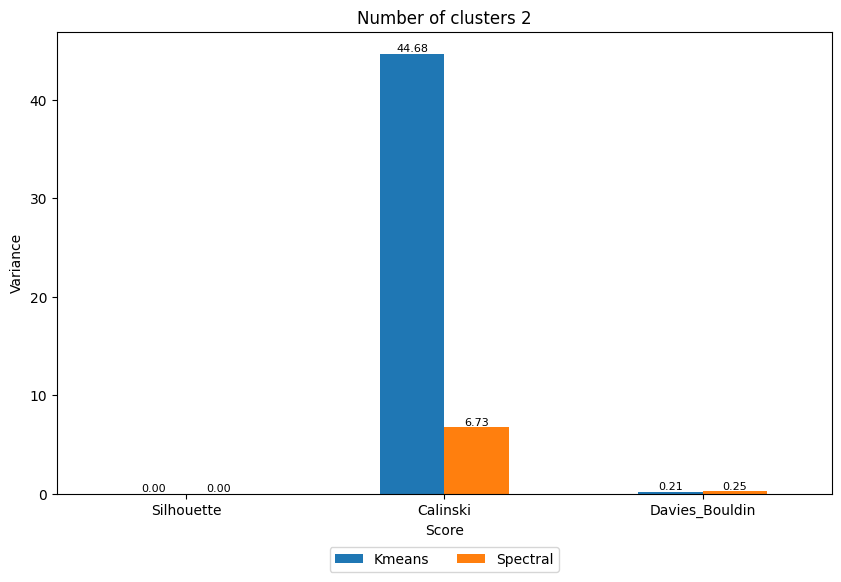

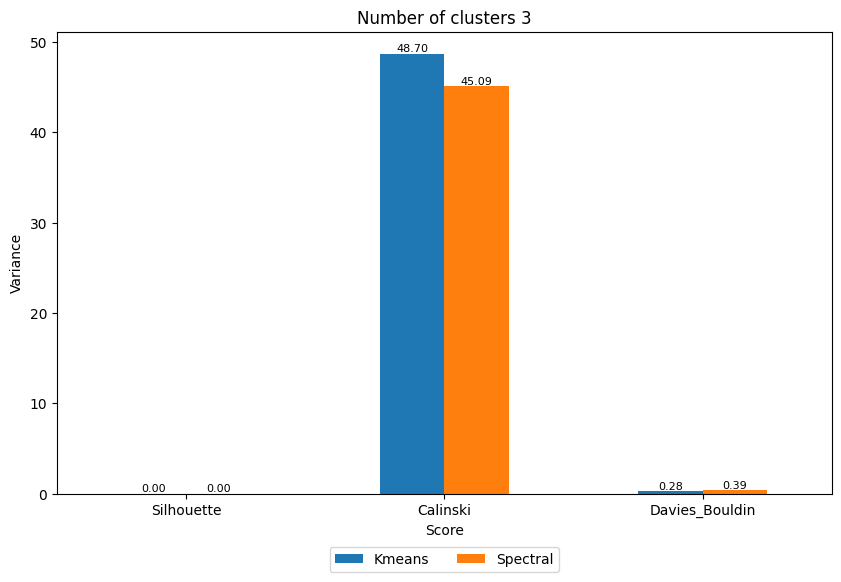

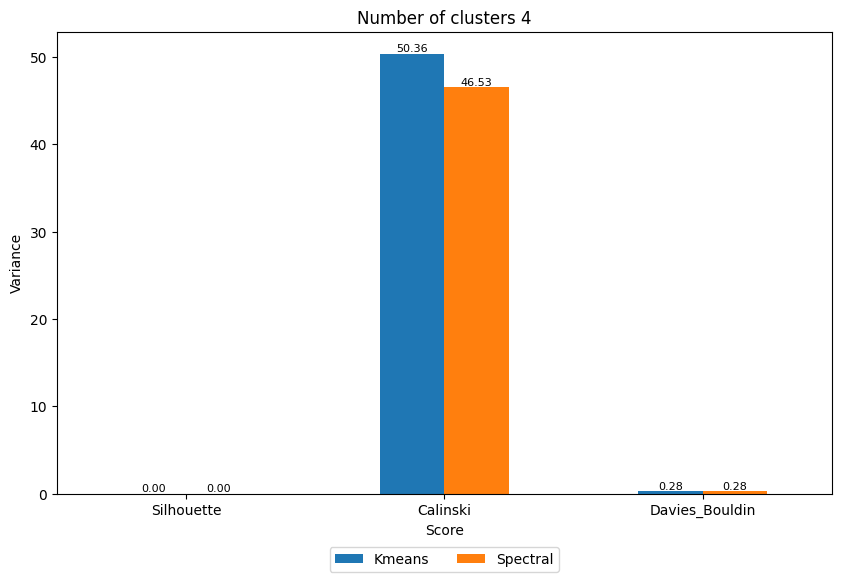

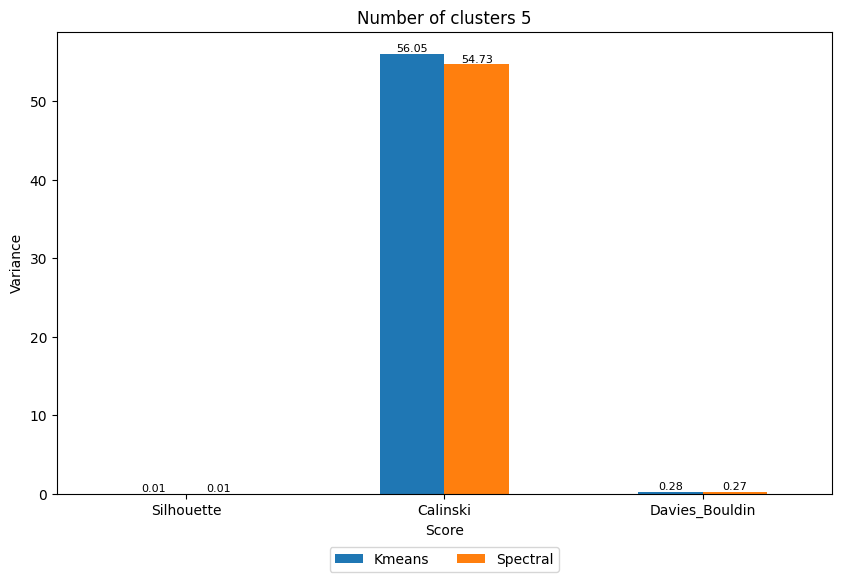

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
clfs_name = ['Kmeans', 'Spectral']
def barplot(score_values, score_names, cluster_nr):
    df = pd.DataFrame(score_values, index=score_names, columns=clfs_name)
    ax = df.plot.bar(rot=0, figsize=(10,6))
    
    
    # Add score names below the bars
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=len(clfs_name))
    ax.set_xlabel('Score')
    ax.set_ylabel('Variance')
    ax.set_xticklabels(score_names)
    ax.set_title('Number of clusters ' + str(cluster_nr))
    
    # Add exact values above the bars
    for i in ax.containers:
        ax.bar_label(i, label_type='edge', fmt='%.2f', fontsize=8)
    
    plt.show()
for cluster_nr in nr_clusters_list:
    score_values = [silhoutte_variances[cluster_nr], calinski_variances[cluster_nr], davies_variances[cluster_nr]]
    score_names = ['Silhouette', 'Calinski', 'Davies_Bouldin']
    barplot(score_values, score_names, cluster_nr)